In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../..'))) # access sibling directories
sys.path.append("C:\\Users\\lasse\\Documents\\GitHub\\BayesFlow")

from src.python.settings import summary_meta_validation, evidence_meta_validation
from src.python.networks import HierarchicalInvariantNetwork, EvidentialNetwork
from src.python.models import HierarchicalNormalSimulator, MainSimulator
from src.python.helpers import n_clust_obs_f_f, get_preds_and_bfs
from src.python.visualization import perf_tester, plot_calibration_curve_uncertainty

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.experimental import CosineDecayRestarts
from tensorflow.keras.optimizers import Adam
from functools import partial
from time import perf_counter
from datetime import datetime, timezone, timedelta
import matplotlib.pyplot as plt

from bayesflow.trainers import ModelComparisonTrainer
from bayesflow.amortizers import MultiModelAmortizer 
from bayesflow.losses import log_loss

In [2]:
# Hack to correctly set facecolor to white
# matplotlib 3.5 only sets facecolor if a plot was already created 
_ = plt.figure()
plt.rcParams['figure.facecolor'] = 'w'

<Figure size 432x288 with 0 Axes>

# Model formulation

$$
\begin{align}
x_n &\sim \mathcal{N}(\theta_l, \sigma^2) \text{ for } n=1,...,N \\
\theta_l &\sim \mathcal{N}(\mu, \tau^2) \text{ for } l=1,...,L\\
\sigma^2 &\sim Half-Normal(\sigma_s)\\
\mu &\sim \mathcal{N}(\mu_0, \tau_0)\\
\tau^2 &\sim Half-Normal(\sigma_t)\\
\end{align}
$$

$$
\begin{align}
&\text{Null Model }M_0 \text{: } \mu=0\\
&\text{Alternative Model }M_1 \text{: } \mu \text{ allowed to differ from 0} \\
\end{align}
$$

# Set up networks

In [3]:
summary_net = HierarchicalInvariantNetwork(summary_meta_validation)
evidence_net = EvidentialNetwork(evidence_meta_validation)

amortizer = MultiModelAmortizer(evidence_net, summary_net)

simulator = MainSimulator(HierarchicalNormalSimulator())

In [4]:
# Cosine Decay with Restarts
initial_lr = 0.0005
first_decay_steps = 1000
t_mul = 2
m_mul = 0.9
alpha = 0.2
lr_schedule_restart = CosineDecayRestarts(
    initial_lr, first_decay_steps, t_mul=t_mul, m_mul=m_mul, alpha=alpha
    )

# Checkpoint path for loading pretrained network and saving the final network
trial_folder = 'checkpoints_fixed'
checkpoint_path = os.path.join(os.getcwd(), trial_folder)

trainer = ModelComparisonTrainer(
    network=amortizer, 
    generative_model=simulator, 
    loss=partial(log_loss, kl_weight=0),
    optimizer=partial(Adam, lr_schedule_restart),
    checkpoint_path=checkpoint_path,
    skip_checks=True,
    )

Networks loaded from c:\Users\lasse\Dropbox\Uni Mannheim\M.Sc\4. Semester\Masterarbeit\Coding\notebooks\01_calibration_validation\checkpoints_fixed\ckpt-10


# Train & validate

In [4]:
training_time_start = perf_counter()
losses = trainer.train_online(epochs=10, iterations_per_epoch=1000, batch_size=32, n_obs=n_clust_obs_f_f)
training_time_stop = perf_counter()

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/1000 [00:00<?, ?it/s]

ECE = 0.032


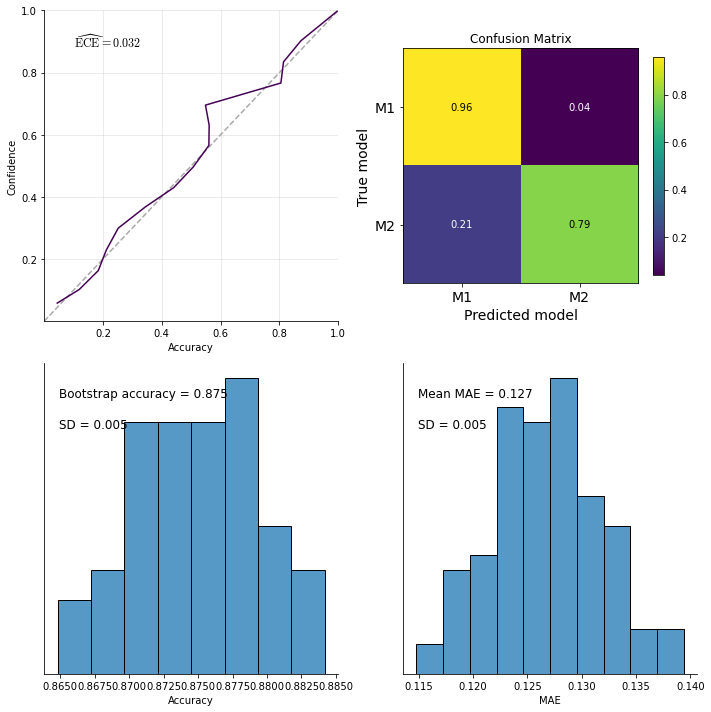

In [5]:
# Validation
n_val = 5000
m_val, _, x_val = simulator(n_val, n_clust_obs_f_f())
val_data = {'X' : x_val, 'm' : m_val}

perf_tester(evidence_net, summary_net, val_data, n_cal_bins=15)

ECE = 0.056
ECE = 0.036
ECE = 0.038
ECE = 0.033
ECE = 0.035
ECE = 0.025
ECE = 0.051
ECE = 0.052
ECE = 0.047
ECE = 0.023


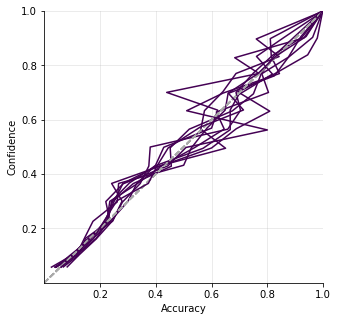

In [6]:
from src.python.visualization import plot_calibration_curve
fig, ax = plt.subplots(figsize=(5,5))

for i in range(10):
    m_val, _, x_val = simulator(n_val, n_clust_obs_f_f())
    val_data = {'X' : x_val, 'm' : m_val}

    # Compute model predictions in chunks so GPU memory does not blow-up
    m_soft = tf.concat([evidence_net.predict(summary_net(x_chunk))['m_probs'][:, 1] for x_chunk in tf.split(val_data['X'], 20)], axis=0).numpy()
    m_hard = (m_soft > 0.5).astype(np.int32)
    m_true = val_data['m'][:, 1]
    plot_calibration_curve(m_true, m_soft, n_bins=15, ax=ax, show_ece=False)

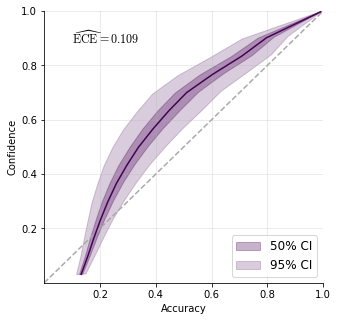

In [8]:
# Calibration curve with uncertainty

# Get Alphas
alphas = tf.concat([evidence_net(summary_net(x_chunk)) for x_chunk in tf.split(val_data['X'], 500)], axis=0).numpy()

# Sample from dirichlet
n_samples = 10000
n_datasets = alphas.shape[0]
pm_samples = np.stack([np.random.dirichlet(alphas[n, :], size=n_samples) for n in range(n_datasets)], axis=0)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
narrow_ci = [0.25, 0.75]
wide_ci = [0.025, 0.975]

m_true = val_data['m'][:, 1]
pm_samples_model = pm_samples[:, :, 1]
plot_calibration_curve_uncertainty(m_true, pm_samples_model, narrow_ci=narrow_ci, wide_ci=wide_ci, n_bins=15, ax=ax)

# Save
#plt.savefig('calibration_fixed.png', dpi=300, bbox_inches='tight')

In [23]:
pm_samples_bayesflow = tf.concat([evidence_net.sample(summary_net(x_chunk), n_samples=10000) for x_chunk in tf.split(val_data['X'], 500)], axis=0).numpy()

In [30]:
pm_samples_bayesflow = evidence_net.sample(summary_net(val_data['X']), n_samples=10000)

In [34]:
pm_samples_bayesflow.shape

(10000, 5000, 2)

In [43]:
# TEMPORARY: TRY OUT WITH BAYESFLOW SAMPLE METHOD

# bins for sampled cal curves
from sklearn.calibration import calibration_curve
n_bins=15

# Get bins & ECE for each sample from the learned dirichlet distribution
probs_true = np.zeros((n_samples, n_bins))
probs_pred = np.zeros((n_samples, n_bins))

m_true = val_data['m'][:, 0]

for n in range(n_samples):
    m_soft = pm_samples_bayesflow[n, :, 0]
    probs_true[n, :], probs_pred[n, :] = calibration_curve(m_true, m_soft, n_bins=n_bins)
cal_err = np.mean(np.abs(probs_true - probs_pred))

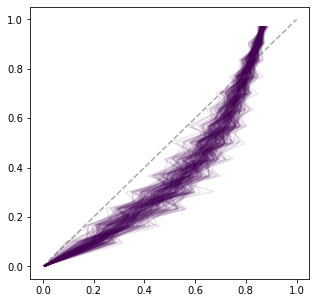

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot((0,1), (0,1), '--', color='darkgrey')
for i in range(200):
    ax.plot(probs_true[i,:], probs_pred[i,:], color='#440154FF', alpha=0.1)

In [35]:
pm_samples.shape

(5000, 10000, 2)

In [27]:
pm_samples_bayesflow.shape

(5000000, 10, 2)

why does sampled curve + ece deviate so much from single curve?
- sampling induces variability? -> but median/mean lines are also off
- averaging over bins not correct? -> but ECEs are also off for single samples! (see hist)

In [39]:
from sklearn.calibration import calibration_curve

# bins for single cal curve
preds = evidence_net.predict(summary_net(val_data['X']))['m_probs'][:,1]
calibration_curve(m_true, preds, n_bins=15)

(array([0.04669261, 0.11158798, 0.15142276, 0.2890625 , 0.2295082 ,
        0.34375   , 0.43119266, 0.53731343, 0.47916667, 0.58536585,
        0.71794872, 0.8       , 0.9047619 , 0.92727273, 0.99386161]),
 array([0.05729763, 0.1023251 , 0.16175126, 0.23046799, 0.29982132,
        0.36526629, 0.43083816, 0.49885262, 0.56707694, 0.63343648,
        0.70204915, 0.76418155, 0.83429582, 0.90623828, 0.99744577]))

In [47]:
np.linspace(0, 1, 15 + 1)

array([0.        , 0.06666667, 0.13333333, 0.2       , 0.26666667,
       0.33333333, 0.4       , 0.46666667, 0.53333333, 0.6       ,
       0.66666667, 0.73333333, 0.8       , 0.86666667, 0.93333333,
       1.        ])

In [14]:
# bins for sampled cal curves
from sklearn.calibration import calibration_curve
n_bins=15

# Get bins & ECE for each sample from the learned dirichlet distribution
probs_true = np.zeros((n_samples, n_bins))
probs_pred = np.zeros((n_samples, n_bins))

for n in range(n_samples):
    m_soft = pm_samples_model[:, n]
    probs_true[n, :], probs_pred[n, :] = calibration_curve(m_true, m_soft, n_bins=n_bins)
cal_err = np.mean(np.abs(probs_true - probs_pred))

In [15]:
pm_samples_model.shape

(5000, 10000)

In [20]:
m_true.shape

(5000,)

In [16]:
probs_true.shape

(10000, 15)

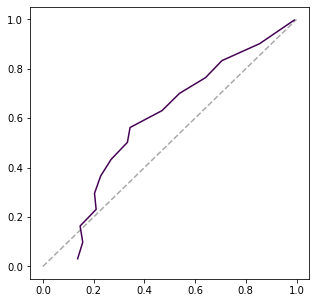

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot((0,1), (0,1), '--', color='darkgrey')
for i in range(1):
    ax.plot(probs_true[i,:], probs_pred[i,:], color='#440154FF')

In [53]:
probs_pred

array([[0.03119878, 0.09806067, 0.16365402, ..., 0.83296483, 0.9017585 ,
        0.99716036],
       [0.03192277, 0.09735803, 0.1636928 , ..., 0.83461444, 0.9060835 ,
        0.9970997 ],
       [0.03092143, 0.09810124, 0.16403336, ..., 0.83720665, 0.90296071,
        0.99707109],
       ...,
       [0.03019627, 0.09756683, 0.16587527, ..., 0.83370028, 0.9017204 ,
        0.99701176],
       [0.03123161, 0.09648891, 0.16451533, ..., 0.82993548, 0.90234595,
        0.99733364],
       [0.03057987, 0.09739701, 0.16387213, ..., 0.83282428, 0.90041773,
        0.99681945]])

In [43]:
probs_true - probs_pred

array([[ 0.10584193,  0.0591042 , -0.01691489, ..., -0.12708247,
        -0.0469198 , -0.0059371 ],
       [ 0.09536749,  0.06732788, -0.02270063, ..., -0.18878111,
         0.03269201, -0.00586202],
       [ 0.0931737 ,  0.05858079,  0.01053023, ..., -0.17682929,
        -0.15296071, -0.00639126],
       ...,
       [ 0.09262871,  0.07535324, -0.00421245, ..., -0.07814472,
        -0.14787425, -0.00630138],
       [ 0.09155715,  0.05531078, -0.04546772, ..., -0.18707833,
        -0.10547095, -0.00176577],
       [ 0.0970101 ,  0.05244526,  0.01220011, ..., -0.07282428,
        -0.13375106, -0.00826359]])

(array([   2.,   22.,  189.,  941., 2463., 3097., 2250.,  867.,  152.,
          17.]),
 array([0.07251616, 0.07870349, 0.08489083, 0.09107817, 0.09726551,
        0.10345284, 0.10964018, 0.11582752, 0.12201486, 0.1282022 ,
        0.13438953]),
 <BarContainer object of 10 artists>)

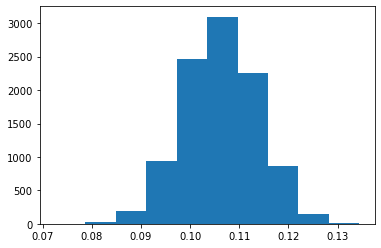

In [44]:
# ECE distribution over samples
plt.hist(np.mean(np.abs(probs_true - probs_pred), axis=1))

## Plot PMPs (dirichlet mean) against sampled PMPs

In [49]:
# Get PMPs (mean of dirichlet)
alphas0 = np.sum(alphas, axis=1, keepdims=True)
means = alphas / alphas0

# Filter for probabilities for m2
means_m2 = means[:,1]
pm_samples_m2 = pm_samples[:,:,1]

In [75]:
# Sort by PMPs
means_m2_indices = means_m2.argsort()
sorted_means_m2 = means_m2[means_m2_indices]
sorted_samples_m2 = pm_samples_m2[means_m2_indices, :]

# Get quantiles of samples
lower_bound, upper_bound = np.quantile(sorted_samples_m2, q=[0.025, 0.975], axis=1)

# Get median
sample_median = np.squeeze(np.quantile(sorted_samples_m2, q=[0.5], axis=1))

# Get mean
sample_mean = np.mean(sorted_samples_m2, axis=1)

### Plot PMPs sorted separately

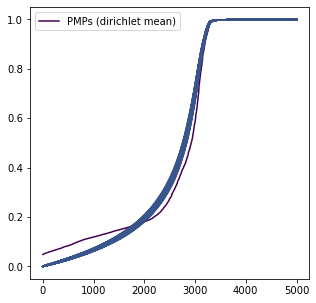

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
x_axis = np.linspace(1,means_m2.shape[0], num=means_m2.shape[0])

# Plot dirichlet mean
ax.plot(x_axis, np.sort(means_m2), color='#440154FF', label='PMPs (dirichlet mean)')

# Plot single samples
for i in range(10000):
    ax.plot(x_axis, np.sort(pm_samples_m2[:,i]), color='#39568CFF', alpha=0.1)

ax.legend()

### Plot PMPs sorted by PMPs (dirichlet mean)

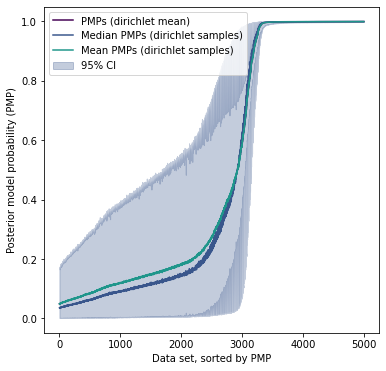

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
x_axis = np.linspace(1,means_m2.shape[0], num=means_m2.shape[0])
ax.plot(x_axis, sorted_means_m2, color='#440154FF', label='PMPs (dirichlet mean)')
ax.plot(x_axis, sample_median, color='#39568CFF', label='Median PMPs (dirichlet samples)')
ax.plot(x_axis, sample_mean, color='#1F968BFF', label='Mean PMPs (dirichlet samples)')
ax.fill_between(x_axis, lower_bound, upper_bound, color='#39568CFF', alpha=0.3, label='95% CI')
ax.set_xlabel('Data set, sorted by PMP')
ax.set_ylabel('Posterior model probability (PMP)')
ax.legend()

In [207]:
sorted_samples_m2[:,0]

array([0.15597532, 0.00109933, 0.00746314, ..., 0.99998844, 0.999992  ,
       0.99985591])

In [14]:
# Save training meta-information for bridge sampling comparison?
save_training_vars = False

if save_training_vars:
    folder = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'data', '01_calibration_validation')

    np.save(os.path.join(folder, 'training_time_start'), training_time_start, allow_pickle=True)
    np.save(os.path.join(folder, 'training_time_stop'), training_time_stop, allow_pickle=True)
    np.save(os.path.join(folder, 'losses'), losses, allow_pickle=True)

# Calculate Bayes factors for bridge sampling comparison

In [25]:
# Import training meta-information? (if network was loaded from checkpoint)
import_training_vars = True

if import_training_vars:
    folder = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'data', '01_calibration_validation')

    training_time_start = np.load(os.path.join(folder, 'training_time_start.npy'), allow_pickle=True)
    training_time_stop = np.load(os.path.join(folder, 'training_time_stop.npy'), allow_pickle=True)
    losses = np.load(os.path.join(folder, 'losses.npy'), allow_pickle=True).item()

In [29]:
# Import test data
val_folder = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'data', '02_bridge_sampling_comparison')
data_filename = "test_data.npy"
test_data = np.load(os.path.join(val_folder, data_filename), allow_pickle=True).item()

In [32]:
# Get NN predictions
comparison_results = get_preds_and_bfs(evidence_net, summary_net, test_data, training_time_start, training_time_stop, losses)
comparison_results.head(5)

,dataset,true_model,m0_prob,m1_prob,selected_model,bayes_factor,training_time,inference_time,final_epoch_loss
0,1,0,0.795071,0.204929,0,0.257750,722.951457,0.000696,0.293996
1,2,0,0.872942,0.127058,0,0.145552,722.951457,0.000696,0.293996
2,3,0,0.881408,0.118592,0,0.134549,722.951457,0.000696,0.293996
3,4,1,0.000513,0.999487,1,1949.839070,722.951457,0.000696,0.293996
4,5,0,0.880935,0.119065,0,0.135157,722.951457,0.000696,0.293996


In [34]:
# Export results
local_timezone = datetime.now(timezone(timedelta(0))).astimezone().tzinfo
filename = pd.Timestamp.today(tz=local_timezone).strftime('%Y_%m_%d_BF_NN_fixed')
comparison_folder = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'data', '02_bridge_sampling_comparison')

comparison_results.to_csv(os.path.join(comparison_folder, filename), index = False)